# 5. SOCAT, CMEMS, & NOAA data

----------

Almost all of the code in this script is documented elsewhere, either in one of the other scripts I've uploaded to Github or in one of Lexi's scripts. The new code starts with the NOAA dataset, toward the bottom.  

What I was trying to do here was to get the ocean-atmosphere flux for a given day and graph that over the eddy contours. I was not able to finish this project, but I left comments at the bottom of the script about what I was planning to do and where I got stuck.

----------

Sydney Paige Kim 

Date Created: 08/16/2021

Last Edited: 08/20/2021

In [1]:
import csv
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

## import SOCAT

In [2]:
np_SOCAT_North_Asia = np.genfromtxt("SOCAT_data_North_Asia_Pacific_nohours.csv",delimiter=',')
np_SOCAT_North_America = np.genfromtxt("SOCAT_data_North_America_Pacific_nohours.csv",delimiter=',')
np_SOCAT_Tropical_Asia = np.genfromtxt("SOCAT_data_Tropical_Asia_Pacific_nohours.csv",delimiter=',')
np_SOCAT_Tropical_America = np.genfromtxt("SOCAT_data_Tropical_America_Pacific_nohours.csv",delimiter=',')

In [3]:
np_SOCAT_unfiltered = np.concatenate((np_SOCAT_North_Asia,np_SOCAT_North_America[1:],np_SOCAT_Tropical_Asia[1:],np_SOCAT_Tropical_America[1:]),axis=0)

In [4]:
years_to_remove = np.arange(1962.,2000.)
print(years_to_remove)

np_SOCAT = np.copy(np_SOCAT_unfiltered)  

[1962. 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973.
 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985.
 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997.
 1998. 1999.]


In [5]:
years_to_remove = np.append(years_to_remove, [2020.], axis=0)
print(years_to_remove)

[1962. 1963. 1964. 1965. 1966. 1967. 1968. 1969. 1970. 1971. 1972. 1973.
 1974. 1975. 1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985.
 1986. 1987. 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997.
 1998. 1999. 2020.]


In [6]:
for yr in years_to_remove:
    rows_to_remove = np.argwhere(np_SOCAT[:,0]==yr)
    np_SOCAT = np.delete(np_SOCAT,rows_to_remove,axis=0)

In [7]:
year = np_SOCAT[1:,0]
month = np_SOCAT[1:,1]
day = np_SOCAT[1:,2]
lat = np_SOCAT[1:,3]
lon = np_SOCAT[1:,4]
fco2 = np_SOCAT[1:,5]

### visualize_fco2(date) 

In [8]:
def visualize_fco2(date):
    """
    Input
        date - Format YYYYMMDD
        socat_data - array with data
        
    Output
        Plot of fco2 measurements on a given date. 
    """
    year = float(date[0:4])
    month = float(date[4:6])
    day = float(date[6:8])

    inds = np.where((np_SOCAT[:,0]==year) & (np_SOCAT[:,1]==month) & (np_SOCAT[:,2]==day))
    data_for_day = np_SOCAT[inds]

    if data_for_day.size == 0:
        print('There is no fco2 data for the date ' + date + '. ' + 'Please try another date.')
    else:
        print('Array data_for_day created.')
    
    lat = data_for_day[1:,3]
    lon = data_for_day[1:,4]
    fco2 = data_for_day[1:,5]
    
    plt.rcParams["figure.figsize"] = (20,10)  #(width, height)
    fig = plt.scatter(lon,lat,c=fco2,s=10,cmap='YlGnBu')
    plt.grid()
    cbar = plt.colorbar()
    cbar.set_label('fCO2 [microatm]', rotation=270, fontsize=15, labelpad=40)
    cbar.ax.tick_params(labelsize=15)   

In [9]:
def filter_fco2(date):
    """
    Input
        date - Format YYYYMMDD
        socat_data - array with data
        
    Output
        Arrays of latitude, longitude, and fco2 measurements for the specified date. 
    """
    year = float(date[0:4])
    month = float(date[4:6])
    day = float(date[6:8])

    inds = np.where((np_SOCAT[:,0]==year) & (np_SOCAT[:,1]==month) & (np_SOCAT[:,2]==day))
    data_for_day = np_SOCAT[inds]

    if data_for_day.size == 0:
        print('There is no fco2 data for the date ' + date + '. ' + 'Please try another date.')
    else:
        print('Array data_for_day created.')
        
    lat = data_for_day[1:,3]
    lon = data_for_day[1:,4]
    fco2 = data_for_day[1:,5]
    
    return lat, lon, fco2

## import CMEMS

In [10]:
eddy_dir = '/Users/kims/Desktop/surface ocean CO2 atlas/CMEMS/'

In [11]:
anti_eddy_data_2012,cyc_eddy_data_2012 = [],[] #set up two empty arrays to read in the data

#First I'm opening the anticyclonic dataset and reading the first decade of data into an array
with open(eddy_dir + 'anticyc_eddy_data_minage27_20000101_to_20191231.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    print('Reading anticyclonic eddy file...')
    
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row) #this is just to check the header; there will be 'empty' columns because the boundary coords will take up many columns
        
        else:
            if i %100000 == 0: # This shows the progress of how many data points we've gone through; might take a minute
                print(i)

            if int(row[0][0:4])<2013 and int(row[0][0:4])>2011: #Get only the first year of data so it is just easier to work with for now
                anti_eddy_data_2012.append(row)
        i += 1
        
        
# Now I'm just doing the same thing for the cyclonic eddy data
with open(eddy_dir + 'cyclonic_eddy_data_minage27_20000101_to_20191231.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    print('Reading cyclonic eddy file...')
    
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row)
        
        else:
            if i %100000 == 0: 
                print(i)

            if int(row[0][0:4])<2013 and int(row[0][0:4])>2011: 
                cyc_eddy_data_2012.append(row)
        i += 1

Reading anticyclonic eddy file...
['Date', 'Eddy ID', 'Age (days)', 'Area (km^2)', 'Amplitude (cm)', 'Translation Speed (m/s)', 'Boundary Coords', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
11

In [12]:
'''
#LEXI'S VERSION, IN CASE I CREATE DISASTER

anti_eddy_data_2000,cyc_eddy_data_2000 = [],[] #set up two empty arrays to read in the data

#First I'm opening the anticyclonic dataset and reading the first decade of data into an array
with open(eddy_dir + 'anticyc_eddy_data_minage27_20000101_to_20191231.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    print('Reading anticyclonic eddy file...')
    
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row) #this is just to check the header; there will be 'empty' columns because the boundary coords will take up many columns
        
        else:
            if i %100000 == 0: # This shows the progress of how many data points we've gone through; might take a minute
                print(i)

            if int(row[0][0:4])<2001: #Get only the first year of data so it is just easier to work with for now
                anti_eddy_data_2000.append(row)
        i += 1
        
        
# Now I'm just doing the same thing for the cyclonic eddy data
with open(eddy_dir + 'cyclonic_eddy_data_minage27_20000101_to_20191231.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    
    print('Reading cyclonic eddy file...')
    
    i = 0
    for row in csv_reader:
        if i == 0:
            print(row)
        
        else:
            if i %100000 == 0: 
                print(i)

            if int(row[0][0:4])<2001: 
                cyc_eddy_data_2000.append(row)
        i += 1

'''

"\n#LEXI'S VERSION, IN CASE I CREATE DISASTER\n\nanti_eddy_data_2000,cyc_eddy_data_2000 = [],[] #set up two empty arrays to read in the data\n\n#First I'm opening the anticyclonic dataset and reading the first decade of data into an array\nwith open(eddy_dir + 'anticyc_eddy_data_minage27_20000101_to_20191231.csv') as csv_file:\n    csv_reader = csv.reader(csv_file, delimiter=',')\n    \n    print('Reading anticyclonic eddy file...')\n    \n    i = 0\n    for row in csv_reader:\n        if i == 0:\n            print(row) #this is just to check the header; there will be 'empty' columns because the boundary coords will take up many columns\n        \n        else:\n            if i %100000 == 0: # This shows the progress of how many data points we've gone through; might take a minute\n                print(i)\n\n            if int(row[0][0:4])<2001: #Get only the first year of data so it is just easier to work with for now\n                anti_eddy_data_2000.append(row)\n        i += 1\n

In [13]:
# Convert the arrays into numpy arrays so they are easier to work with; might take a minute
anti_eddy_data_2012 = np.array(anti_eddy_data_2012)
cyc_eddy_data_2012 = np.array(cyc_eddy_data_2012)

### visualize_eddy_field(date,anti_eddy_data,cyc_eddy_data) 

In [14]:
def visualize_eddy_field(date,anti_eddy_data,cyc_eddy_data):
    """
    Input
        date - Format YYYYMMDD
        anti_eddy_data - array with data
        cyc_eddy_data - array with data
        
    Output
        Plot of eddy contours on a given date. This function can be used to plot eddy contours with other data as well.
    """

    anti_day_inds = np.where(anti_eddy_data[:,0] == str(date))
    cyc_day_inds = np.where(cyc_eddy_data[:,0] == str(date))
    
    anti_eddy_bnds = np.squeeze(anti_eddy_data[anti_day_inds,6:])
    cyc_eddy_bnds = np.squeeze(cyc_eddy_data[cyc_day_inds,6:])
    
    i = 0 #counter
    for bnds in anti_eddy_bnds:
        x_values = [float(coord) for coord in bnds[0::2] if str(coord) != '']
        y_values = [float(coord) for coord in bnds[1::2] if str(coord) != '']

        if i ==0:
            ax.plot(x_values,y_values,c='#991414',label='Anticyclonic Eddy') #create label for just the first eddy to feed into the legend
        else:
            ax.plot(x_values,y_values,c='#991414') #This color is produced via a hex code, check out https://htmlcolorcodes.com/
        i+=1
    
    j = 0 #counter
    for bnds in cyc_eddy_bnds:    
        x_values = [float(coord) for coord in bnds[0::2] if str(coord) != '']
        y_values = [float(coord) for coord in bnds[1::2] if str(coord) != '']
        
        if j ==0:
            ax.plot(x_values,y_values,c='#08088A',label='Cyclonic Eddy')
        else:
            ax.plot(x_values,y_values,c='#08088A') 
        j+=1
    
    # Create legend for cyclonic & anticyclonic
    ax.legend(loc='upper left', fontsize = 20)
        
    # Add labels and set font sizes    
    ax.set_title('%s-%s-%s North Pacific Mesoscale Eddy Field'%(str(date)[4:6],str(date)[6:8],str(date)[0:4]),fontsize=20)
    ax.set_xlabel('Longitude',fontsize=20)
    ax.set_ylabel('Latitude',fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14)

## visualize the North Pacific by date (SOCAT & CMEMS)

Array data_for_day created.


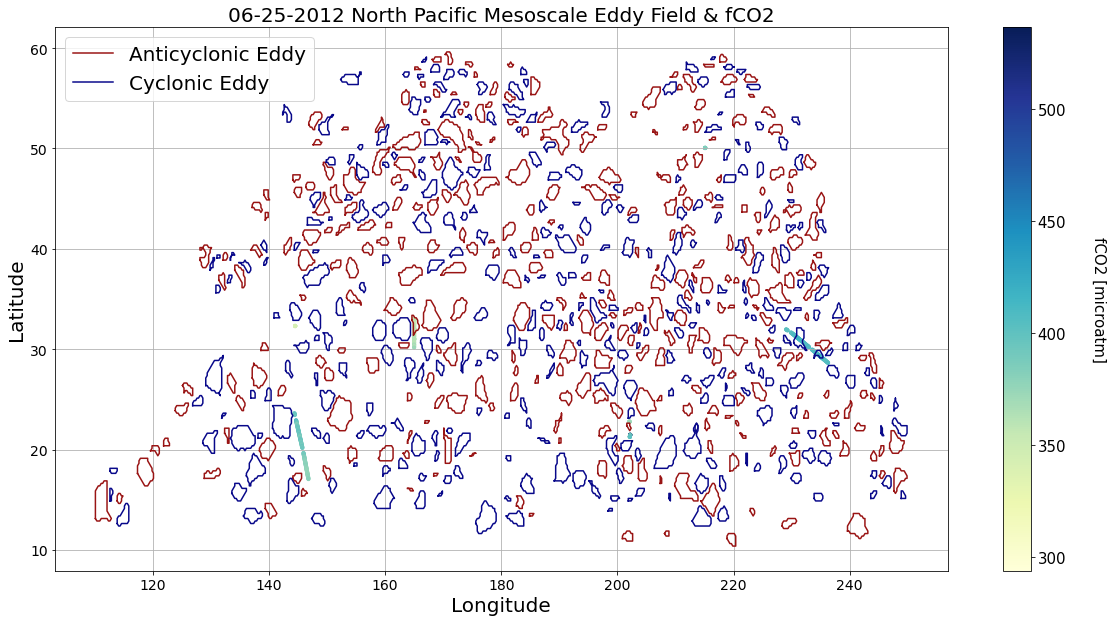

In [15]:
date = '20120625'   # okay 201206 dates: 14, 15, 22, 23, 24, 25, 26

# Plot CMEMS data
fig,ax = plt.subplots(1,1,figsize=(20,10))
visualize_eddy_field(date,anti_eddy_data_2012,cyc_eddy_data_2012)

# Plot SOCAT data
visualize_fco2(date)

# override the title
plt.title('%s-%s-%s North Pacific Mesoscale Eddy Field & fCO2'%(str(date)[4:6],str(date)[6:8],str(date)[0:4]),fontsize=20)

plt.show()

### check_if_in_eddy(date,lon,lat,eddy_data)

In [16]:
def check_if_in_eddy(date,lon,lat,eddy_data):
    """
    Inputs
        date - Format YYYYMMDD
        lat - 10 to 70 (degrees north); latitude of the data point
        lon - input should be positive coordinates (110 to 250 degrees); longitude of the data point
        eddy_array - Name of the eddy dataset to look through (cyc or anti)
        
    Outputs
        0 if point is not in eddy, OR eddy ID if point is in an eddy
    """
    
    #Open .csv file with eddy data
    day_inds = np.where(eddy_data[:,0] == str(date)) #find all eddies from the requested date
    eddy_bnds = np.squeeze(eddy_data[day_inds,6:]) #get the eddy boundary coordinates & remove extraneous dimensions of the array
    eddy_ids = np.squeeze(eddy_data[day_inds,1]) #get the eddy ids
    
    #Iterate through the data for each eddy that is present on the requested date
    in_eddy = 0 #flag to determine if the point is in an eddy
    i = 0 #counter
    for eddy in eddy_bnds:
        bnds = [float(coord) for coord in eddy if str(coord) != ''] #Remove nan values from the eddy boundaries
        
        #Seperate the x & y values 
        x_values = bnds[0::2]
        y_values = bnds[1::2]
        
        #Check if the point is far away from the eddy we are checking right now, and if so, skip to the next eddy
        if lon > np.max(x_values) or lon < np.min(x_values) or lat > np.max(y_values) or lat < np.min(y_values):
            i += 1 #have to step up the counter here because the loop will skip the rest of the code here
            continue
        
        #If the point is close to the eddy, reformat the data so it is readable by the Polygon function
        poly_pts = [(x_values[pt],y_values[pt]) for pt in np.arange(0,len(x_values))]
        polygon = Polygon(poly_pts)
        data_pt = Point(lon,lat)
        
        if polygon.contains(data_pt):
            in_eddy = int(eddy_ids[i])
            break
                
        i += 1
    
    return in_eddy

In [17]:
print(len(lon))

1466061


In [18]:
#Create an array that indicates if the data points are in an eddy or not.

lat, lon, fco2 = filter_fco2(date) 

Array data_for_day created.


In [19]:
anti_eddies,cyc_eddies = [],[]

for i in np.arange(0,len(lon)):
    if i%10 == 0:
        print(i)
    anti_eddies.append(check_if_in_eddy(int(date),lon[i],lat[i],anti_eddy_data_2012)) #check the anticyc eddy dataset
    cyc_eddies.append(check_if_in_eddy(int(date),lon[i],lat[i],cyc_eddy_data_2012)) #check the cyclonic eddy dataset
        
#Convert to numpy arrays
anti_eddies = np.array(anti_eddies)
cyc_eddies = np.array(cyc_eddies) 

print(anti_eddies)
print(cyc_eddies)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
[     0      0      0      0      0      0      0 154331 154331 154331
 154331 154331 154331 154331 154331 154331 154331 154331 154331 154331
 154331 154331 154331 154331 154331 154331 154331 154331 154331 154331
 154331 154331 154331 154331 154331 154331 154331 154331 154331 154331
 154331 154331 154331      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0     

In [20]:
fco2_in_anti_inds = np.squeeze(np.where(anti_eddies != 0))
fco2_in_cyc_inds = np.squeeze(np.where(cyc_eddies != 0))

In [21]:
#Get eddy dataset info EXCEPT for the boundaries from this day for both datasets
anti_day_inds = np.where(anti_eddy_data_2012[:,0] == date) 
anti_day_eddy_data = np.squeeze(anti_eddy_data_2012[anti_day_inds,:6]) 

cyc_day_inds = np.where(cyc_eddy_data_2012[:,0] == date) 
cyc_day_eddy_data = np.squeeze(cyc_eddy_data_2012[cyc_day_inds,:6]) 

In [22]:
#Initialize empty arrays to add data to later
anti_co2_values, anti_eddy_ages, anti_eddy_sizes, anti_eddy_amps, anti_eddy_speeds = [],[],[],[],[]
cyc_co2_values, cyc_eddy_ages, cyc_eddy_sizes, cyc_eddy_amps, cyc_eddy_speeds = [],[],[],[],[]

for ind in fco2_in_anti_inds: #iterate through all of the fco2 data points in an anticyclonic eddy        
    
    #info from the point data    
    eddy_id = anti_eddies[ind]    
    anti_co2_values.append(fco2[ind])
    
    #info from the eddy dataset
    eddy_ind = np.squeeze(np.where(anti_day_eddy_data[:,1] == str(eddy_id))) #get the row in the CSV with the data for this eddy on this day
        
    anti_eddy_ages.append(float(anti_day_eddy_data[eddy_ind,2])) #add the eddy age from the CSV
    anti_eddy_sizes.append(float(anti_day_eddy_data[eddy_ind,3])) #add the eddy size from the CSV
    anti_eddy_amps.append(float(anti_day_eddy_data[eddy_ind,4])) #add the eddy amplitude from the CSV
    anti_eddy_speeds.append(float(anti_day_eddy_data[eddy_ind,5])) #add the eddy translation speed from the CSV
        
for ind in fco2_in_cyc_inds: #now iterate through all of the co2 data points in a cyclonic eddy  
    
    #info from the point data    
    eddy_id = cyc_eddies[ind]
    cyc_co2_values.append(fco2[ind])
    
    #info from the eddy dataset
    eddy_ind = np.squeeze(np.where(cyc_day_eddy_data[:,1] == str(eddy_id))) #get the row in the CSV with the data for this eddy on this day\
        
    cyc_eddy_ages.append(float(cyc_day_eddy_data[eddy_ind,2])) #add the eddy age from the CSV
    cyc_eddy_sizes.append(float(cyc_day_eddy_data[eddy_ind,3])) #add the eddy size from the CSV
    cyc_eddy_amps.append(float(cyc_day_eddy_data[eddy_ind,4])) #add the eddy amplitude from the CSV
    cyc_eddy_speeds.append(float(cyc_day_eddy_data[eddy_ind,5])) #add the eddy translation speed from the CSV

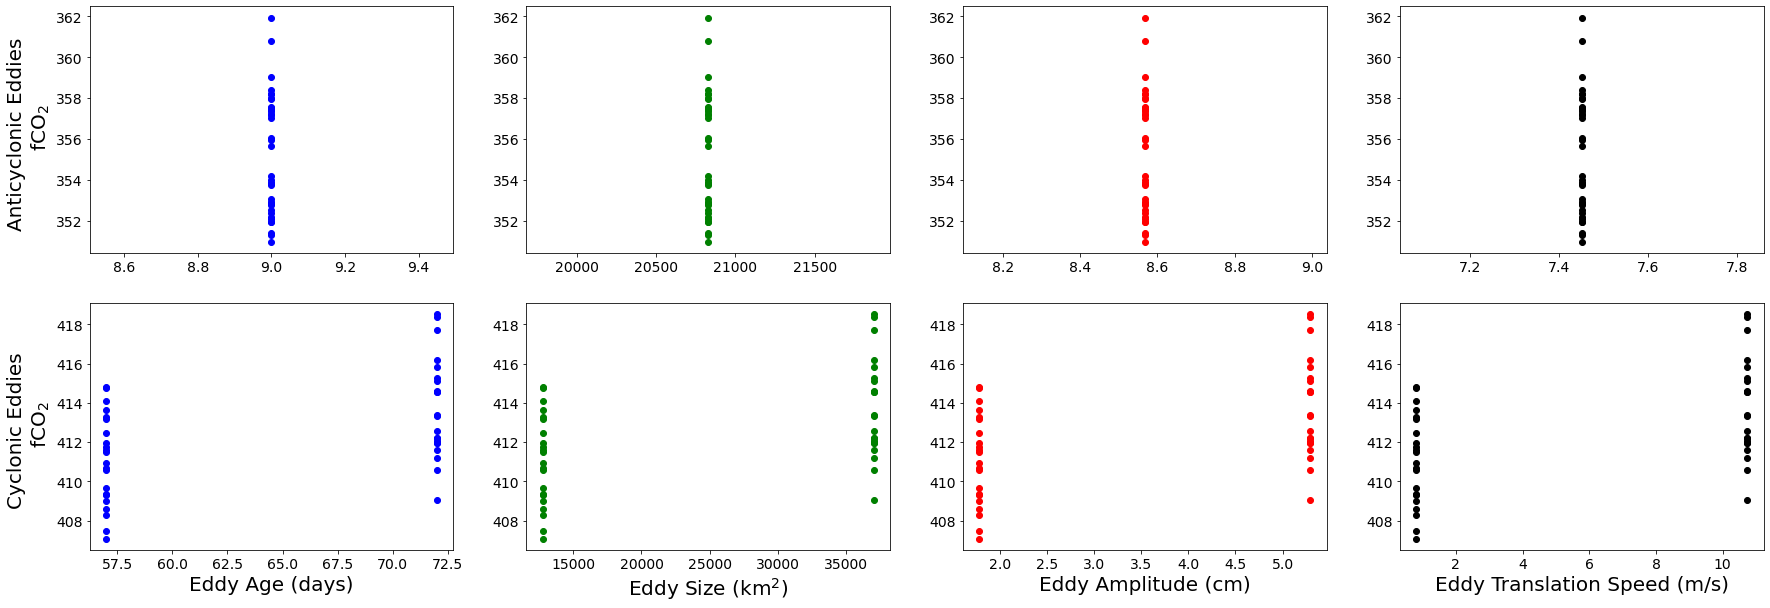

In [23]:
fig,ax = plt.subplots(2,4,figsize=(30,10))

# Plot the anticyclonic relationships
ax[0,0].scatter(anti_eddy_ages,anti_co2_values,c='b')
ax[0,1].scatter(anti_eddy_sizes,anti_co2_values,c='g')
ax[0,2].scatter(anti_eddy_amps,anti_co2_values,c='r')
ax[0,3].scatter(anti_eddy_speeds,anti_co2_values,c='k')

# Plot the cyclonic relationships
ax[1,0].scatter(cyc_eddy_ages,cyc_co2_values,c='b')
ax[1,1].scatter(cyc_eddy_sizes,cyc_co2_values,c='g')
ax[1,2].scatter(cyc_eddy_amps,cyc_co2_values,c='r')
ax[1,3].scatter(cyc_eddy_speeds,cyc_co2_values,c='k')

# Add labels and set font sizes
x_labels = ['Eddy Age (days)', 'Eddy Size (km$^2$)', 'Eddy Amplitude (cm)', 'Eddy Translation Speed (m/s)']
ax[1,0].set_xlabel(x_labels[0],fontsize=20)
ax[1,1].set_xlabel(x_labels[1],fontsize=20)
ax[1,2].set_xlabel(x_labels[2],fontsize=20)
ax[1,3].set_xlabel(x_labels[3],fontsize=20)

ax[0,0].set_ylabel('Anticyclonic Eddies \n fCO$_2$',fontsize=20)
ax[1,0].set_ylabel('Cyclonic Eddies \n fCO$_2$',fontsize=20)

for i in np.arange(0,2):
    for j in np.arange(0,4):
        ax[i,j].tick_params(axis='both', which='major', labelsize=14) #changes the size of the number labels

## import NOAA

In [24]:
# Download files within date range from NOAA carbontracker; Current files available are from 01/01/2000 - 03/29/2019

import urllib.request
import pandas as pd
from datetime import date,timedelta

sdate = date(2012,6,25)
edate = date(2012,6,26) 

date_list = [str(i)[:10] for i in pd.date_range(sdate,edate-timedelta(days=1),freq='d')]

for d in date_list:
    print('Downloading file for %s'%(d))
    url = 'https://gml.noaa.gov/aftp/products/carbontracker/co2/molefractions/co2_total/CT2019B.molefrac_glb3x2_%s.nc'%(d)
    urllib.request.urlretrieve(url,'CT2019B.molefrac_glb3x2_%s.nc'%(d))

<ipython-input-25-94248116a0d0>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = plt.pcolormesh(ds.longitude,ds.latitude,ds.co2[0,0])


Text(0.5, 1.0, '3-hr average micromol C mol$^{-1}$ air')

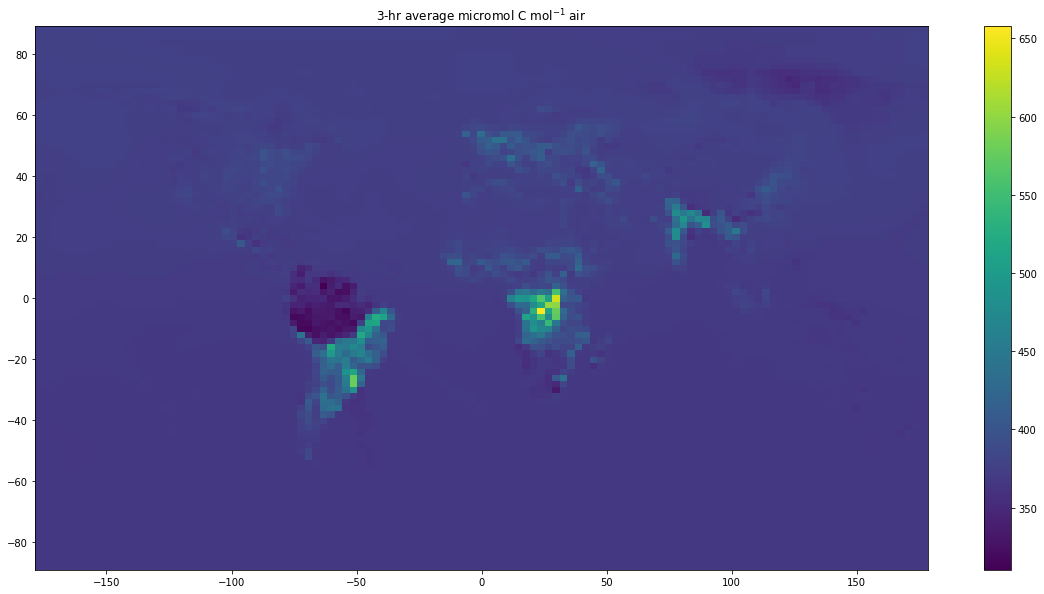

In [25]:
data_dir = '/Users/kims/'
ds = xr.open_dataset(data_dir + 'CT2019B.molefrac_glb3x2_2000-03-22.nc')
plot = plt.pcolormesh(ds.longitude,ds.latitude,ds.co2[0,0])
plt.colorbar(plot)
plt.title('3-hr average micromol C mol$^{-1}$ air')

In [26]:
#intermediate longitude list. puts the points in order
int_lon = np.concatenate((ds.longitude[60:],ds.longitude[0:60]),axis=0) 

#initializing a new longitude list
new_lon = ([])

# this converts the NOAA data to a 0 to 360 degree range instead of a -180 to 180 degree range
for lon in int_lon:
    if lon < 0:
        lon = lon + 360.0
    new_lon.append(lon)
        
print(new_lon)

[1.5, 4.5, 7.5, 10.5, 13.5, 16.5, 19.5, 22.5, 25.5, 28.5, 31.5, 34.5, 37.5, 40.5, 43.5, 46.5, 49.5, 52.5, 55.5, 58.5, 61.5, 64.5, 67.5, 70.5, 73.5, 76.5, 79.5, 82.5, 85.5, 88.5, 91.5, 94.5, 97.5, 100.5, 103.5, 106.5, 109.5, 112.5, 115.5, 118.5, 121.5, 124.5, 127.5, 130.5, 133.5, 136.5, 139.5, 142.5, 145.5, 148.5, 151.5, 154.5, 157.5, 160.5, 163.5, 166.5, 169.5, 172.5, 175.5, 178.5, 181.5, 184.5, 187.5, 190.5, 193.5, 196.5, 199.5, 202.5, 205.5, 208.5, 211.5, 214.5, 217.5, 220.5, 223.5, 226.5, 229.5, 232.5, 235.5, 238.5, 241.5, 244.5, 247.5, 250.5, 253.5, 256.5, 259.5, 262.5, 265.5, 268.5, 271.5, 274.5, 277.5, 280.5, 283.5, 286.5, 289.5, 292.5, 295.5, 298.5, 301.5, 304.5, 307.5, 310.5, 313.5, 316.5, 319.5, 322.5, 325.5, 328.5, 331.5, 334.5, 337.5, 340.5, 343.5, 346.5, 349.5, 352.5, 355.5, 358.5]


In [27]:
# this rearranges the CO2 data to match the new order of the longitude data
new_CO2 = np.concatenate((ds.co2[0,0,:,60:],ds.co2[0,0,:,0:60]),axis=1)

## visualize the North Pacific by date (SOCAT, CMEMS, & NOAA)

Array data_for_day created.


<ipython-input-29-296f259866a3>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plot = plt.pcolormesh(new_lon,ds.latitude,new_CO2,cmap='jet')


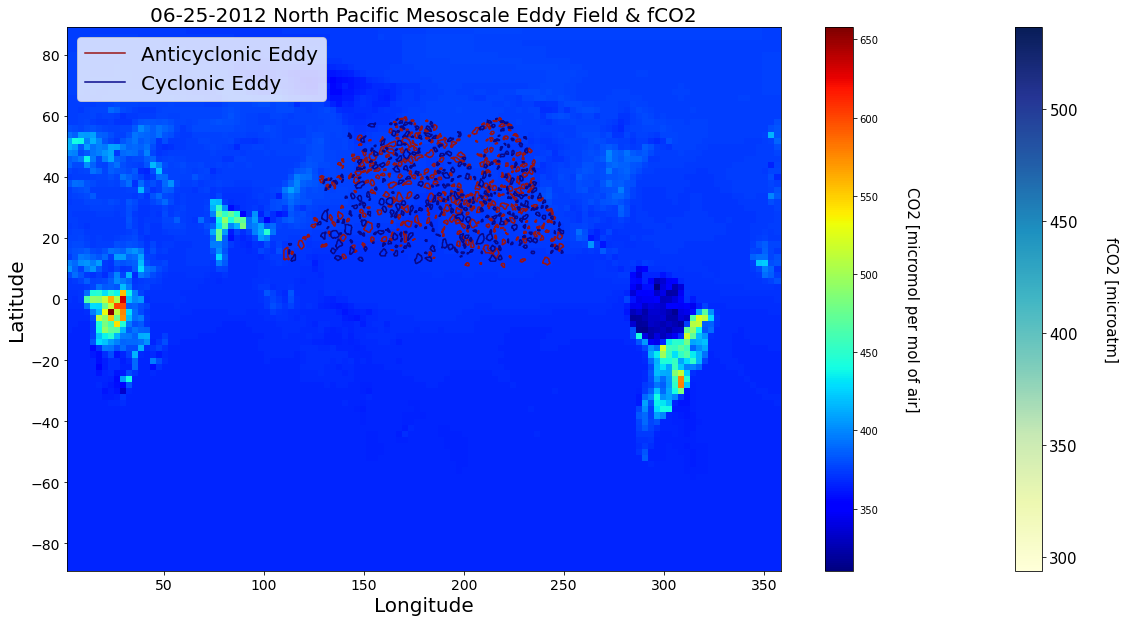

In [29]:
date = '20120625'

# Plot CMEMS data
fig,ax = plt.subplots(1,1,figsize=(20,10))
visualize_eddy_field(date,anti_eddy_data_2012,cyc_eddy_data_2012)

# Plot SOCAT data
visualize_fco2(date)

# Plot NOAA data
plot = plt.pcolormesh(new_lon,ds.latitude,new_CO2,cmap='jet')
cbar = plt.colorbar(plot)
cbar.set_label('CO2 [micromol per mol of air]', rotation=270, fontsize=15, labelpad=40)

# override the title
plt.title('%s-%s-%s North Pacific Mesoscale Eddy Field & fCO2'%(str(date)[4:6],str(date)[6:8],str(date)[0:4]),fontsize=20)

plt.show()

## find flux from SOCAT & NOAA data 

In [30]:
# STEP 1: get SOCAT datapoints

date = '20120625'

lat, lon, fco2 = filter_fco2(date)

print('There are ' + str(len(fco2)) + ' SOCAT fco2 datapoints for the date ' + date + '.')

Array data_for_day created.
There are 345 SOCAT fco2 datapoints for the date 20120625.


In [31]:
# STEP 2: find out what NOAA gridcell these points are in

atm_co2 = []

for i in lat:

    min_lat = ds.latitude[ds.latitude > lat[i]].min()     
    max_lat = ds.latitude[ds.latitude < lat[i]].max()

    min_lon = ds.longitude[ds.longitude > lon[i]].min()  
    max_lon = ds.longitude[ds.longitude < lon[i]].max()

print(min_lat)

# this is where I got stuck. I think the problem is that the dataset values are floats,
# not integers.  

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
'''
Here is what I was planning to do with this code. 

I was going to match each fco2 (SOCAT) value with a co2 value from NOAA, then subtract
one from the other to get the ocean-atmosphere flux. You might have to look into the units
(a conversion factor might make sense) before doing this. Also note that you can define
which direction is positive flux––in other words, it doesn't matter if you do fco2-co2
or co2-fco2, as long as you define it.

Then, I was going to graph it and then do some statistics on it.

Last note: the reason why I chose 20120625 as the date is because the data crosses through
three different eddies, some of which are cyclonic and some of which are anticyclonic.
If you find a day with better data, feel free to replace it.

'''